# Tensorflow Data Pipeline

data input 방법
 * 학습데이터 전체 메모리에 로드
     * 데이터가 많을 경우 메모리 용량 한계
 * generator를 사용하여 batch 사이즈 만큼만 메모리에 로드
     * 학습 전 batch 사이즈 만큼 메모리에 로드 하기 위한 오버헤드 발생
 
tensorflow에서 data pipeline을 만들어 GPU가 학습하는동안 cpu thread가 generator를 prefetch하여 tensorflow 모델에 input 하는 과정을 학습

>참조: [Tensorflow Programmer's Guide Reading Data](https://www.tensorflow.org/programmers_guide/reading_data)
 * generator: python generator를 구현하여 data read
 * tf record: image, annotation 파일을 이용하여 tf record 파일을 생성
 * string_input_producer: file name 큐 생성
 * tf.train.shuffle.batch: batch 큐 생성
 * tf.contrib.dataset: 복잡한 input pipeline을 단순화 하기 위한 API

 * package 설치
     * pip install matplotlib

## Generator

 iterator 를 생성해 주는 function. next()메소드를 이용해 데이터에 순차적으로 접근 가능한 object
 메모리를 효율적으로 사용하기 위해 사용
  * next() 메소드를 통해 차례로 값에 접근할 때마다 메모리에 적재하는 방식이다.

In [53]:
def generator(n):
    i = 0
    while i < n:
        yield i
        i += 1
        
iterator = generator(10)
print (iterator)
for x in range(5):
    print (next(iterator))

<generator object generator at 0x7fabfcfa4fc0>
0
1
2
3
4


In [2]:
import tensorflow as tf
import os
import random
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

_NUM_SHARDS = 5
_DATA_DIR = "/root/data/mnist_png"

def get_filenames_and_classes(dataset_dir, train_val):
    mnist_root = os.path.join(dataset_dir, train_val)
    directories = []
    class_names = []
    print (mnist_root)
    print (os.listdir(mnist_root))
    for filename in os.listdir(mnist_root):
        path = os.path.join(mnist_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    print (directories)
    print (class_names)
    for directory in directories:
        for filename in os.listdir(directory):
            print (filename)
            path = os.path.join(directory, filename)
            photo_filenames.append(path)

    return photo_filenames, sorted(class_names)

training_filenames, training_class_names = get_filenames_and_classes(_DATA_DIR, "training")
validation_filenames, validation_class_names = get_filenames_and_classes(_DATA_DIR, "testing")
print (validation_filenames)

/root/data/mnist_png/training
['5', '1', '4', '7', '0', '3', '9', '2', '8', '6']
['/root/data/mnist_png/training/5', '/root/data/mnist_png/training/1', '/root/data/mnist_png/training/4', '/root/data/mnist_png/training/7', '/root/data/mnist_png/training/0', '/root/data/mnist_png/training/3', '/root/data/mnist_png/training/9', '/root/data/mnist_png/training/2', '/root/data/mnist_png/training/8', '/root/data/mnist_png/training/6']
['5', '1', '4', '7', '0', '3', '9', '2', '8', '6']
25259.png
25411.png
26972.png
19959.png
28271.png
32323.png
22180.png
22156.png
30903.png
20853.png
13300.png
7024.png
57793.png
8056.png
56661.png
55643.png
45024.png
55800.png
10227.png
7323.png
49728.png
57055.png
57132.png
37049.png
29708.png
45780.png
6407.png
31976.png
236.png
2566.png
37662.png
35062.png
55414.png
12488.png
55591.png
31266.png
39197.png
15594.png
50675.png
56229.png
52439.png
27377.png
16210.png
36516.png
23630.png
43488.png
22147.png
24799.png
6735.png
44821.png
26198.png
22268.png
59590

42436.png
48533.png
22887.png
21204.png
46999.png
44667.png
42955.png
58824.png
30030.png
42762.png
35151.png
4015.png
53802.png
11549.png
40393.png
51626.png
45731.png
26857.png
26995.png
34139.png
31779.png
37164.png
59180.png
12092.png
30081.png
14054.png
28748.png
42121.png
36579.png
45018.png
7842.png
46188.png
4076.png
32511.png
3635.png
34932.png
54904.png
37448.png
7081.png
6849.png
39985.png
47278.png
38569.png
37590.png
23146.png
54063.png
35397.png
41682.png
38365.png
43748.png
2622.png
40993.png
53641.png
51231.png
15771.png
24217.png
28360.png
46700.png
26112.png
17172.png
20569.png
8819.png
32001.png
20186.png
56786.png
54604.png
12569.png
54281.png
33137.png
54528.png
36245.png
20390.png
18248.png
29076.png
11417.png
12937.png
29748.png
51794.png
54024.png
30896.png
58871.png
27000.png
1481.png
19160.png
28924.png
17920.png
22821.png
59846.png
52195.png
30928.png
4397.png
26706.png
56127.png
51405.png
7382.png
40840.png
32248.png
11.png
15462.png
57136.png
38564.png
5595

21166.png
49205.png
31280.png
35669.png
16307.png
44994.png
35313.png
42531.png
19753.png
45438.png
43715.png
25898.png
28516.png
27871.png
4763.png
26205.png
10365.png
16536.png
45444.png
11156.png
37650.png
11679.png
17748.png
32718.png
46372.png
25112.png
14056.png
22850.png
16236.png
50051.png
10455.png
38976.png
15776.png
31113.png
10416.png
40658.png
46919.png
42701.png
44680.png
29828.png
8456.png
1060.png
6793.png
24306.png
50453.png
13569.png
54946.png
49392.png
36591.png
31739.png
54557.png
15493.png
14516.png
52451.png
24279.png
20990.png
23886.png
10885.png
21178.png
1676.png
7240.png
49521.png
33374.png
14321.png
47440.png
36711.png
38303.png
28646.png
8423.png
21818.png
43300.png
33949.png
38159.png
40879.png
33416.png
17662.png
9457.png
58965.png
45803.png
30270.png
12133.png
12512.png
36687.png
16233.png
24619.png
15929.png
30592.png
7536.png
3430.png
19441.png
15316.png
34638.png
38545.png
15105.png
13542.png
57192.png
25666.png
24771.png
27707.png
1148.png
32824.png
5

310.png
26388.png
48177.png
40352.png
58033.png
57283.png
3295.png
32612.png
43269.png
4387.png
47553.png
15164.png
22859.png
38235.png
3509.png
38860.png
11342.png
4089.png
5933.png
9875.png
26647.png
22345.png
16509.png
39462.png
41649.png
17727.png
35069.png
23660.png
40314.png
30509.png
19651.png
8530.png
3567.png
51451.png
49899.png
36968.png
26812.png
41150.png
52334.png
44324.png
46029.png
3926.png
59382.png
27182.png
33646.png
54963.png
51671.png
58865.png
45297.png
29320.png
22727.png
28794.png
19243.png
53103.png
14980.png
48441.png
12178.png
8664.png
33868.png
50489.png
41029.png
30996.png
23984.png
30436.png
59820.png
21301.png
41858.png
46107.png
25354.png
55499.png
4435.png
59864.png
4676.png
51287.png
28133.png
6870.png
44220.png
36288.png
52819.png
24143.png
54087.png
35774.png
17706.png
38311.png
17856.png
52431.png
8633.png
31862.png
28906.png
36864.png
35900.png
28318.png
24115.png
16938.png
23818.png
24136.png
42485.png
982.png
13961.png
9110.png
56081.png
1496.png


4454.png
24885.png
44850.png
51593.png
17492.png
17238.png
4180.png
45404.png
48990.png
26281.png
58047.png
37080.png
967.png
10643.png
56484.png
46623.png
33552.png
4274.png
35144.png
2596.png
2176.png
58514.png
28327.png
52448.png
21627.png
36394.png
12194.png
37311.png
1613.png
52200.png
51368.png
44632.png
6546.png
42333.png
4240.png
12247.png
52128.png
25001.png
29115.png
23696.png
36073.png
24437.png
53439.png
8006.png
13291.png
4959.png
54718.png
44279.png
25410.png
1628.png
54358.png
8261.png
53673.png
22285.png
7178.png
17934.png
18831.png
19564.png
7319.png
34733.png
44013.png
29767.png
25175.png
53130.png
14433.png
41722.png
729.png
24506.png
20110.png
6160.png
31522.png
43137.png
2277.png
44694.png
17493.png
52681.png
48840.png
36970.png
17740.png
25218.png
25558.png
55883.png
39386.png
3625.png
57208.png
28464.png
4099.png
22518.png
30113.png
20527.png
52343.png
22968.png
22331.png
14966.png
6256.png
22197.png
1212.png
46561.png
57548.png
30311.png
59139.png
36674.png
2943

20425.png
21503.png
23855.png
25925.png
13765.png
42213.png
31340.png
5046.png
31728.png
39433.png
51382.png
45391.png
51684.png
57375.png
51047.png
46052.png
36314.png
5549.png
19198.png
20484.png
19795.png
48710.png
12019.png
2392.png
20219.png
31436.png
59690.png
27398.png
4169.png
55141.png
38147.png
24039.png
5623.png
20836.png
17590.png
19794.png
4133.png
45611.png
8215.png
50314.png
50567.png
15521.png
4460.png
13271.png
52564.png
41964.png
50879.png
18011.png
6552.png
54563.png
35472.png
58555.png
18398.png
1273.png
39833.png
11886.png
50609.png
19112.png
45718.png
39209.png
42857.png
21096.png
20183.png
16450.png
12760.png
33671.png
44459.png
44998.png
44479.png
30835.png
57819.png
39812.png
39101.png
24292.png
46995.png
34823.png
36897.png
15310.png
13553.png
18000.png
5047.png
59042.png
24767.png
35966.png
44251.png
21223.png
35319.png
52442.png
55004.png
43364.png
51622.png
59900.png
37419.png
34138.png
56659.png
53912.png
7204.png
16982.png
30613.png
55328.png
6729.png
407

42828.png
56359.png
52964.png
43645.png
55882.png
31125.png
57414.png
41161.png
29508.png
5291.png
30798.png
10969.png
46737.png
39752.png
40795.png
39399.png
33153.png
20720.png
39969.png
42036.png
45374.png
57119.png
26417.png
29951.png
37131.png
19912.png
37706.png
21169.png
3255.png
4394.png
44663.png
37064.png
11329.png
30713.png
48377.png
51526.png
22313.png
11517.png
58450.png
46607.png
4254.png
8798.png
39517.png
55237.png
52744.png
56814.png
59602.png
37165.png
38534.png
31423.png
5251.png
31527.png
21641.png
37394.png
12138.png
15106.png
47879.png
1251.png
40214.png
4332.png
7384.png
50721.png
16630.png
35937.png
43669.png
53188.png
8377.png
47402.png
32988.png
55863.png
5089.png
44539.png
31684.png
26499.png
38537.png
53771.png
38220.png
243.png
9086.png
38269.png
4551.png
22097.png
5465.png
31319.png
44185.png
16197.png
5650.png
40018.png
30109.png
26026.png
2986.png
18844.png
47416.png
38506.png
13355.png
41998.png
13056.png
32460.png
56521.png
48247.png
22018.png
9198.png

34084.png
4713.png
21271.png
57916.png
47139.png
40582.png
51834.png
38903.png
36090.png
11712.png
47247.png
27859.png
14202.png
39446.png
702.png
36047.png
46484.png
45596.png
2557.png
33874.png
42552.png
24749.png
30484.png
44859.png
1625.png
18219.png
20886.png
3778.png
59755.png
21614.png
8089.png
15637.png
58575.png
49685.png
41191.png
41052.png
1837.png
49675.png
34305.png
48267.png
49739.png
25757.png
53189.png
29243.png
25714.png
59023.png
58665.png
28690.png
26979.png
28151.png
10689.png
26722.png
577.png
55911.png
45417.png
48350.png
55631.png
16363.png
19550.png
2561.png
10604.png
37335.png
11422.png
13730.png
20551.png
13726.png
51925.png
32793.png
18725.png
54433.png
11914.png
9524.png
31138.png
43265.png
27280.png
28546.png
57073.png
19480.png
39570.png
29101.png
28257.png
36994.png
37787.png
6603.png
7846.png
53014.png
40400.png
44583.png
20840.png
18028.png
24148.png
25152.png
38946.png
12947.png
57995.png
7355.png
46680.png
9742.png
11019.png
46375.png
26258.png
46017.

22829.png
30119.png
17051.png
31194.png
5694.png
11091.png
11683.png
59696.png
44871.png
2864.png
29684.png
33645.png
16888.png
14775.png
2192.png
10168.png
53403.png
36304.png
56704.png
29585.png
57296.png
15504.png
57507.png
4738.png
17360.png
56404.png
16355.png
23753.png
52238.png
43188.png
7855.png
2617.png
7944.png
9158.png
39848.png
42877.png
48929.png
10840.png
11022.png
48059.png
3667.png
28667.png
22202.png
44094.png
53195.png
41383.png
4854.png
13738.png
34416.png
49639.png
51466.png
59595.png
1128.png
28457.png
40099.png
54303.png
27720.png
44474.png
23821.png
48526.png
27931.png
27788.png
48434.png
2624.png
29862.png
31082.png
58074.png
18232.png
34073.png
52617.png
51314.png
4729.png
27427.png
28714.png
38484.png
34246.png
49770.png
7391.png
55907.png
36919.png
8724.png
31470.png
7911.png
29148.png
48604.png
37287.png
23504.png
5560.png
51147.png
55481.png
16227.png
29230.png
14258.png
45190.png
34172.png
56570.png
9422.png
37738.png
16640.png
4653.png
1999.png
52470.png


29476.png
19238.png
7132.png
27480.png
44193.png
40462.png
18626.png
48722.png
3178.png
18584.png
44134.png
41385.png
12211.png
14447.png
22103.png
39290.png
3471.png
54270.png
59394.png
9959.png
46621.png
11714.png
27214.png
50265.png
28418.png
51154.png
4783.png
17643.png
52027.png
35582.png
51555.png
45264.png
43140.png
38991.png
27183.png
1097.png
55960.png
17712.png
47329.png
23873.png
27741.png
48396.png
45759.png
500.png
15322.png
40555.png
5637.png
14692.png
22000.png
8405.png
30251.png
953.png
26830.png
5702.png
15496.png
46005.png
17085.png
98.png
18920.png
20016.png
54535.png
35058.png
10876.png
30754.png
14099.png
12933.png
18939.png
29266.png
48732.png
14454.png
37017.png
48930.png
37643.png
24307.png
9153.png
49156.png
32398.png
42902.png
6576.png
34845.png
16715.png
36644.png
10921.png
35249.png
33854.png
50000.png
57625.png
33357.png
45862.png
42906.png
13376.png
41740.png
56565.png
42056.png
35066.png
21468.png
57941.png
33009.png
56528.png
41608.png
33049.png
57488.pn

54201.png
44497.png
40520.png
57717.png
22963.png
18030.png
55628.png
34171.png
47380.png
47059.png
42398.png
20926.png
27518.png
22643.png
13607.png
37821.png
2816.png
28900.png
31745.png
33911.png
56228.png
13228.png
10644.png
38083.png
56006.png
22721.png
8075.png
55321.png
44888.png
55592.png
52692.png
52191.png
4883.png
56994.png
20423.png
26156.png
36705.png
6033.png
35914.png
11949.png
11570.png
45675.png
9871.png
35381.png
53480.png
20561.png
874.png
37135.png
43070.png
50012.png
36082.png
45436.png
27610.png
50950.png
48806.png
27987.png
48642.png
8505.png
53225.png
14467.png
51274.png
11392.png
49791.png
26702.png
14878.png
34587.png
49091.png
49946.png
26554.png
12345.png
5370.png
39235.png
54296.png
22964.png
56925.png
35156.png
47426.png
45312.png
15372.png
7162.png
59262.png
7433.png
11039.png
48392.png
17208.png
42966.png
32234.png
13937.png
37886.png
5941.png
15937.png
55926.png
38116.png
17062.png
23672.png
5193.png
24350.png
14262.png
30733.png
17460.png
40483.png
315

50217.png
36420.png
50020.png
33701.png
21138.png
3277.png
37541.png
42946.png
50079.png
12069.png
47662.png
16541.png
23673.png
29084.png
15560.png
7538.png
6019.png
47766.png
34044.png
40177.png
20636.png
20216.png
26428.png
26748.png
16413.png
26215.png
58608.png
54601.png
9968.png
5595.png
37126.png
53505.png
58852.png
34975.png
29655.png
39781.png
7478.png
23868.png
11820.png
6149.png
41983.png
55642.png
8059.png
46701.png
36080.png
54504.png
26254.png
27748.png
54048.png
17323.png
17296.png
42597.png
42924.png
36102.png
45178.png
7070.png
20366.png
13032.png
33226.png
41008.png
50177.png
20445.png
49608.png
10480.png
29824.png
30646.png
22359.png
14239.png
33130.png
5209.png
33599.png
3069.png
23998.png
17826.png
27515.png
20667.png
16147.png
24817.png
21879.png
1632.png
41033.png
4124.png
44116.png
14843.png
14436.png
20735.png
32311.png
36521.png
313.png
26155.png
42715.png
7312.png
58054.png
37321.png
47588.png
16588.png
1757.png
44825.png
14687.png
56684.png
24507.png
16580.p

40685.png
21351.png
31917.png
44592.png
57258.png
39640.png
49182.png
14216.png
30698.png
47257.png
36678.png
35741.png
53841.png
25224.png
4788.png
44340.png
7492.png
52718.png
3055.png
26846.png
4117.png
5137.png
12708.png
15253.png
49714.png
37009.png
59243.png
30877.png
27237.png
9428.png
24898.png
28055.png
54843.png
40073.png
53369.png
23111.png
49703.png
34844.png
13326.png
15654.png
13456.png
11208.png
49226.png
4678.png
27863.png
38248.png
18976.png
49833.png
44407.png
14884.png
47899.png
58245.png
4589.png
51185.png
41483.png
7946.png
29301.png
33041.png
11853.png
1038.png
27391.png
53010.png
29472.png
50752.png
30378.png
19586.png
32443.png
4091.png
33738.png
26586.png
39571.png
19315.png
41948.png
110.png
2221.png
47657.png
20241.png
8468.png
5539.png
25565.png
45183.png
42192.png
26861.png
26845.png
53661.png
30069.png
44223.png
58680.png
39895.png
23515.png
2274.png
13898.png
52546.png
902.png
27519.png
29072.png
27087.png
42465.png
43000.png
51827.png
38247.png
18722.png

31947.png
5420.png
26817.png
4856.png
50802.png
5016.png
16237.png
59110.png
28335.png
41427.png
28135.png
30477.png
7079.png
20959.png
32250.png
22200.png
52630.png
54709.png
6307.png
2855.png
40637.png
18198.png
14508.png
7567.png
24732.png
55433.png
19415.png
3659.png
57112.png
51702.png
11420.png
42568.png
55304.png
40948.png
51064.png
33435.png
18255.png
46386.png
18435.png
26201.png
4355.png
45661.png
30596.png
26658.png
12053.png
6168.png
49962.png
49907.png
13771.png
43683.png
46464.png
48681.png
12621.png
53494.png
33094.png
51642.png
52677.png
39145.png
30772.png
30336.png
34928.png
35606.png
53708.png
48640.png
30589.png
30831.png
53237.png
82.png
49819.png
45085.png
15966.png
44502.png
26875.png
17230.png
10200.png
46551.png
12517.png
47246.png
27413.png
51630.png
45125.png
18370.png
35137.png
31454.png
47155.png
46935.png
25147.png
41420.png
12860.png
38785.png
830.png
2004.png
2270.png
27700.png
14040.png
47467.png
55326.png
51589.png
58651.png
37615.png
18585.png
4733.pn

24312.png
5346.png
25799.png
2805.png
51785.png
50077.png
27147.png
8327.png
28935.png
26628.png
18450.png
44061.png
3026.png
34635.png
49088.png
39827.png
14192.png
58199.png
53906.png
10551.png
6495.png
24147.png
15515.png
47857.png
47183.png
3353.png
5791.png
58762.png
18533.png
12782.png
33382.png
48494.png
559.png
24791.png
2679.png
4381.png
24691.png
29604.png
41801.png
48285.png
53996.png
4853.png
51964.png
54625.png
47057.png
41132.png
50597.png
43579.png
7923.png
14553.png
45737.png
45311.png
11431.png
36199.png
935.png
42900.png
15436.png
53651.png
12928.png
17291.png
43846.png
40134.png
9839.png
48375.png
19792.png
20876.png
3293.png
32926.png
47728.png
11704.png
35129.png
16579.png
49744.png
14068.png
24654.png
19877.png
29589.png
7290.png
34376.png
6795.png
7228.png
31479.png
6187.png
32864.png
31881.png
49095.png
39609.png
34986.png
43938.png
25486.png
47085.png
11586.png
5827.png
23935.png
57174.png
16658.png
17027.png
34042.png
11724.png
30407.png
20657.png
56193.png
21

49438.png
35987.png
15739.png
58643.png
33251.png
28297.png
27493.png
34452.png
30635.png
4357.png
20945.png
45082.png
528.png
57493.png
14679.png
54505.png
7136.png
19455.png
55430.png
26351.png
24344.png
6498.png
8210.png
37396.png
28144.png
39995.png
46988.png
34770.png
37039.png
17878.png
32948.png
28023.png
25988.png
18114.png
18466.png
46121.png
19538.png
9918.png
48256.png
4637.png
21110.png
48891.png
47719.png
27048.png
56911.png
19128.png
26515.png
55182.png
46099.png
9611.png
1294.png
16000.png
11568.png
16059.png
35307.png
32965.png
27358.png
53701.png
2358.png
36696.png
32270.png
2682.png
50790.png
53605.png
48140.png
36367.png
13934.png
36275.png
50274.png
11942.png
24959.png
36751.png
5609.png
19470.png
13632.png
2413.png
49661.png
51467.png
27105.png
38979.png
21190.png
29126.png
32717.png
34510.png
14648.png
2611.png
13327.png
47051.png
52862.png
31023.png
49266.png
50410.png
52733.png
7979.png
39499.png
11311.png
20640.png
40939.png
28490.png
6284.png
14477.png
41180.p

2637.png
2590.png
35219.png
28798.png
36293.png
10037.png
27556.png
36826.png
46491.png
30820.png
37831.png
331.png
40596.png
23186.png
18903.png
57157.png
50580.png
45447.png
36772.png
23566.png
13133.png
35497.png
51924.png
37788.png
1750.png
18125.png
49624.png
16273.png
20142.png
6874.png
45839.png
30715.png
4018.png
2196.png
43892.png
39177.png
19331.png
57935.png
31110.png
35426.png
19040.png
24385.png
19563.png
44941.png
42475.png
25638.png
26716.png
35297.png
34960.png
22277.png
30036.png
51378.png
59509.png
19062.png
15220.png
59453.png
28339.png
32455.png
32140.png
15114.png
7559.png
20124.png
48823.png
30507.png
126.png
27807.png
23049.png
25030.png
547.png
18849.png
34658.png
53047.png
47106.png
37581.png
43655.png
24486.png
24201.png
53320.png
30582.png
21113.png
28251.png
50276.png
41889.png
59791.png
40124.png
5311.png
45609.png
7970.png
9943.png
19356.png
19095.png
37028.png
47383.png
28711.png
29813.png
2930.png
58863.png
43281.png
35988.png
14634.png
28115.png
58536.p

58770.png
33006.png
35033.png
30295.png
4533.png
4620.png
25730.png
40775.png
48346.png
18608.png
5913.png
31521.png
11357.png
15526.png
13881.png
56405.png
3098.png
41842.png
54288.png
34783.png
28678.png
53798.png
14437.png
34121.png
35734.png
15687.png
33474.png
19571.png
55274.png
39632.png
15183.png
6551.png
11253.png
51311.png
27483.png
4110.png
56673.png
27156.png
42143.png
37140.png
48219.png
52198.png
58922.png
12423.png
32058.png
43263.png
22291.png
22763.png
40874.png
51159.png
42450.png
13224.png
1503.png
31397.png
27244.png
45460.png
28552.png
53289.png
31228.png
44070.png
28508.png
55213.png
17933.png
8042.png
15788.png
26345.png
7452.png
53398.png
33550.png
46393.png
15401.png
13614.png
37340.png
38152.png
48262.png
36895.png
31708.png
24685.png
50113.png
47713.png
8347.png
39893.png
25031.png
939.png
59320.png
26641.png
50092.png
44617.png
56545.png
22160.png
21977.png
12673.png
16493.png
6257.png
28898.png
8627.png
54537.png
45630.png
57143.png
51624.png
24257.png
4147

8030.png
1903.png
9384.png
1581.png
3721.png
5688.png
2563.png
5365.png
8265.png
254.png
8974.png
9618.png
9919.png
1366.png
2407.png
1359.png
7998.png
1741.png
9958.png
6326.png
9113.png
2132.png
4669.png
846.png
41.png
4677.png
7573.png
5551.png
3054.png
7584.png
4993.png
9546.png
9576.png
1104.png
636.png
5205.png
6346.png
9186.png
3333.png
5317.png
1498.png
6762.png
3277.png
2252.png
5959.png
7544.png
7538.png
9765.png
6471.png
8417.png
2567.png
9968.png
6149.png
1750.png
9141.png
6874.png
4485.png
9212.png
4175.png
5240.png
8510.png
6208.png
3616.png
262.png
7230.png
7267.png
8555.png
6539.png
6768.png
2642.png
1156.png
1660.png
7098.png
3743.png
5714.png
4099.png
9859.png
8573.png
8218.png
5177.png
1770.png
5640.png
9640.png
1401.png
4612.png
1126.png
5422.png
4228.png
4865.png
1799.png
7219.png
1494.png
6663.png
3349.png
223.png
9285.png
1754.png
17.png
5610.png
6589.png
3425.png
3604.png
9031.png
2874.png
6458.png
8749.png
3360.png
6316.png
2285.png
9486.png
3373.png
2474.png
4

8876.png
6382.png
2086.png
4106.png
4635.png
2681.png
1539.png
8981.png
8785.png
1114.png
8970.png
8206.png
3686.png
8867.png
1028.png
753.png
3078.png
2587.png
2348.png
4397.png
6736.png
3261.png
727.png
8489.png
3300.png
5245.png
7097.png
4234.png
2865.png
4437.png
9579.png
5356.png
8246.png
2551.png
6511.png
1134.png
334.png
847.png
8010.png
4352.png
4996.png
5796.png
4796.png
4004.png
9192.png
8429.png
3977.png
1953.png
6646.png
3896.png
5330.png
3150.png
8856.png
2712.png
5912.png
795.png
9558.png
2139.png
51.png
4940.png
323.png
3493.png
1779.png
5019.png
2893.png
3670.png
1020.png
7484.png
3390.png
310.png
6862.png
93.png
2424.png
5214.png
2690.png
9083.png
7333.png
1480.png
5293.png
6481.png
4435.png
6535.png
7798.png
9157.png
1310.png
982.png
2770.png
4904.png
2128.png
7821.png
8308.png
6096.png
912.png
8766.png
801.png
4220.png
7690.png
2347.png
8370.png
7675.png
573.png
4755.png
6085.png
7157.png
6413.png
1997.png
6722.png
3326.png
3131.png
173.png
6664.png
9056.png
2284.png

3554.png
2750.png
1017.png
5286.png
724.png
6685.png
1079.png
3749.png
5354.png
5853.png
9127.png
2672.png
3118.png
5136.png
8622.png
559.png
9976.png
8446.png
2465.png
7158.png
9678.png
5007.png
6207.png
6187.png
5230.png
5702.png
98.png
1014.png
353.png
4547.png
7188.png
4336.png
1943.png
6847.png
3725.png
4081.png
4347.png
8143.png
2000.png
9756.png
6094.png
4838.png
9775.png
8542.png
21.png
7159.png
8852.png
7906.png
6334.png
4952.png
3304.png
6355.png
6749.png
9793.png
3135.png
5994.png
8063.png
8116.png
9693.png
140.png
1880.png
7939.png
9999.png
2535.png
3428.png
5484.png
6605.png
2738.png
2047.png
8326.png
66.png
22.png
4814.png
2791.png
1458.png
6402.png
1035.png
1969.png
8197.png
9269.png
9053.png
7305.png
3690.png
3238.png
6896.png
3000.png
384.png
3424.png
6167.png
9178.png
5467.png
9040.png
5469.png
6258.png
6792.png
8474.png
769.png
9632.png
5727.png
5066.png
5030.png
4980.png
8517.png
2156.png
2754.png
3427.png
8083.png
600.png
3156.png
3222.png
8944.png
6782.png
5558.pn

In [6]:
def generator(filenames, class_names, data_len, batch_size, epoch):
    class_names_to_ids = dict(zip(class_names, range(len(class_names))))
    print (class_names)
    print (class_names_to_ids)
    
    for i in range(epoch):
        i = 0
        while i < data_len:

            if (i + batch_size) > data_len:
                batch_count = data_len - i
            else:
                batch_count = batch_size

            batch_data = np.zeros((batch_count, 28, 28))
            batch_label = np.zeros((batch_count, 1))

            for j in range(batch_count):
                filename = filenames[i+j]
                batch_data[j] = plt.imread(filename)
                #'/root/data/mnist_png/testing/6/4698.png' -> '/root/data/mnist_png/testing/6' -> '6'
                class_name = os.path.basename(os.path.dirname(filenames[i]))
                #string to int
                batch_label[j] = class_names_to_ids[class_name]

            yield batch_data, batch_label
            i = i + batch_size

data_len = len(validation_filenames)
batch_size = 14
epoch = 2
gen = generator(validation_filenames, validation_class_names, data_len, batch_size, epoch)

gen_count = np.ceil(data_len/batch_size)

for i in range(int(gen_count)*epoch):
    batch_data, batch_label = next(gen)
    print (np.shape(batch_data), np.shape(batch_label))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'8': 8, '0': 0, '5': 5, '2': 2, '6': 6, '7': 7, '3': 3, '1': 1, '9': 9, '4': 4}
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28

(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) 

(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) 

(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) (14, 1)
(14, 28, 28) 

## tf record

 여러곳에 흩어져 있는 이미지와 annotation을 binary 파일로 저장. <br/>
 분산된 이미지 대신 통합된 binary 파일 read 
  * image와 label을 파일 하나로 저장 
  * hdd를 사용할 경우, disk 헤더 이동시간을 줄여 파일 읽기 시간을 최적화

In [10]:
#Helper class that provides TensorFlow image coding utilities.
class ImageReader(object):

    def __init__(self):
        # Initializes function that decodes 1 channel png data.
        self._decode_png_data = tf.placeholder(dtype=tf.string)
        self._decode_png = tf.image.decode_png(self._decode_png_data, channels=1)

    def read_image_dims(self, sess, image_data):
        image = self.decode_png(sess, image_data)
        return image.shape[0], image.shape[1]
    #decode string image data to int image data
    def decode_png(self, sess, image_data):
        image = sess.run(self._decode_png,
                         feed_dict={self._decode_png_data: image_data})
        return image

# make tensorflow record file name
def get_dataset_filename(dataset_dir, split_name, shard_id):
    output_filename = 'mnist_%s_%05d-of-%05d.tfrecord' % (
        split_name, shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

# Creates a TensorFlow Record Feature with value as a 64 bit integer.
def int64_feature(values):
    # if value is not tuple or list, make value to list
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

# Creates a TensorFlow Record Feature with value as a byte array
def bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

#define tesnorflow record format
def image_to_tfexample(image_data, image_format, height, width, class_id):
    return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
    }))

#Converts the given filenames to a TFRecord dataset.
#
#      Args:
#        split_name: The name of the dataset, either 'train' or 'validation'.
#        filenames: A list of absolute paths to png or jpg images.
#        class_names_to_ids: A dictionary from class names (strings) to ids
#          (integers).
#        dataset_dir: The directory where the converted datasets are stored.

def convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir):
    assert split_name in ['train', 'validation']
    
    num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))

    print ("file len: ",len(filenames), "num per shard: ", num_per_shard)

    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:

            for shard_id in range(_NUM_SHARDS):
                output_filename = get_dataset_filename(
                    dataset_dir, split_name, shard_id)

                #print (output_filename)
                
                #write tensorflow record file
                #create tfrecord_write
                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = shard_id * num_per_shard
                    end_ndx = min((shard_id + 1) * num_per_shard, len(filenames))
                    for i in range(start_ndx, end_ndx):
                        sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                            i + 1, len(filenames), shard_id))
                        sys.stdout.flush()

                        # Read the filename:
                        image_data = tf.gfile.FastGFile(filenames[i], 'rb').read()
                        height, width = image_reader.read_image_dims(sess, image_data)

                        class_name = os.path.basename(os.path.dirname(filenames[i]))
                        class_id = class_names_to_ids[class_name]
                        
                        #make tensorflow record object and write
                        example = image_to_tfexample(
                            image_data, b'png', height, width, class_id)
                        tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()

random.shuffle(training_filenames)
random.shuffle(validation_filenames)

class_names_to_ids = dict(zip(training_class_names, range(len(training_class_names))))
print (class_names_to_ids)

convert_dataset('train', training_filenames, class_names_to_ids,
                     _DATA_DIR)
convert_dataset('validation', validation_filenames, class_names_to_ids,
                     _DATA_DIR)

{'8': 8, '0': 0, '5': 5, '2': 2, '6': 6, '7': 7, '3': 3, '1': 1, '9': 9, '4': 4}
file len:  60000 num per shard:  12000
  allow_growth: true
}
allow_soft_placement: true
)
>> Converting image 60000/60000 shard 4
file len:  10000 num per shard:  2000
  allow_growth: true
}
allow_soft_placement: true
)
>> Converting image 10000/10000 shard 4


12000 12000 12000 12000 12000
b'png' 3 28 28
  allow_growth: true
}
allow_soft_placement: true
)
(28, 28)


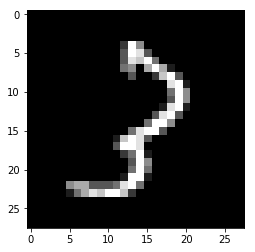

In [12]:
tf_filename = "/root/data/mnist_png/mnist_train_00000-of-00005.tfrecord"
image = []
format = []
label = []
height = []
width = []

#decoding from tf_filename
for serialized_example in tf.python_io.tf_record_iterator(tf_filename):
    #create tf record object and parsing
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image.append(example.features.feature['image/encoded'].bytes_list.value)
    format.append(example.features.feature['image/format'].bytes_list.value)
    label.append(example.features.feature['image/class/label'].int64_list.value)
    height.append(example.features.feature['image/height'].int64_list.value)
    width.append(example.features.feature['image/width'].int64_list.value)

print (len(image), len(format), len(label), len(height), len(width))
print (format[1][0], label[1][0], height[1][0], width[1][0])

with tf.Session('') as sess:
    #bytes_list image data to int image data
    image = tf.image.decode_png(image[1][0], channels=1)
    image_shape = tf.stack([height[1][0], width[1][0]])
    image = tf.reshape(image, image_shape)
    image = sess.run(image)


print (image.shape)
plt.imshow(image,  cmap='gray')
plt.show()

## string_input_producer
 
 filename을 produce 하기 위한 큐 <br/>
 FIFO 큐를 만들어 reader가 읽기 전까지 fiilename을 홀딩

In [14]:
filename_list = []
num_epochs = 1

for i in range(_NUM_SHARDS):
    filename_list.append(os.path.join(_DATA_DIR,  
                                      'mnist_validation_%05d-of-%05d.tfrecord' % (i, _NUM_SHARDS)))

print (filename_list)
filename_queue = tf.train.string_input_producer(filename_list, num_epochs=num_epochs)
reader = tf.TFRecordReader()
key, value = reader.read(filename_queue)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    step = 0 
    try:
        while True:
            #read tensorflow object
            print (sess.run([key]))
            step = step + 1
    
    except tf.errors.OutOfRangeError:
        print("Done training ")
        print (step)
    finally:
        coord.request_stop()
        coord.join(threads)
        print ("thread Done:")

['/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord']
  allow_growth: true
}
allow_soft_placement: true
)
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:0']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:453']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:892']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:1292']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:1667']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:2052']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:2386']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:2797']
[b'/root/data/mnist_png/mnist_validation_00000-of-0

[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:49174']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:49573']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:49891']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:50269']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:50678']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:51039']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:51361']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:51818']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:52205']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:52557']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:52984']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:53375']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:53785']
[b'/root/data/mnist_png/mnist_validation_00000-of-0

[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:396260']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:396710']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:397132']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:397580']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:397972']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:398276']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:398694']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:399135']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:399536']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:399847']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:400248']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:400655']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:401053']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:439702']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:440093']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:440443']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:440835']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:441224']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:441580']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:441979']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:442340']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:442701']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:443109']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:443468']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:443934']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:444363']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:756247']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:756639']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:757035']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:757321']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:757712']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:758096']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:758478']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:758839']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:759243']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:759691']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:760073']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:760492']
[b'/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord:760895']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:351266']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:351574']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:351968']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:352383']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:352776']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:353166']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:353605']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:354027']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:354319']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:354759']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:355168']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:355560']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:356014']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:397176']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:397606']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:398007']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:398448']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:398802']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:399256']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:399565']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:399933']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:400293']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:400714']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:401122']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:401574']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:401952']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:745691']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:746118']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:746599']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:746969']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:747377']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:747687']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:748077']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:748392']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:748832']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:749264']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:749671']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:750083']
[b'/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord:750502']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:3861']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:4172']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:4620']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:5032']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:5407']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:5705']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:6106']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:6533']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:6918']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:7347']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:7733']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:8092']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:8460']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord

[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:333550']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:333837']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:334258']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:334662']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:335058']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:335437']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:335852']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:336293']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:336742']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:337167']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:337575']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:337965']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:338347']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:701636']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:702031']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:702439']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:702826']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:703229']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:703589']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:703964']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:704372']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:704778']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:705152']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:705558']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:705942']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:706296']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:746408']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:746776']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:747140']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:747594']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:747928']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:748327']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:748762']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:749060']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:749432']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:749881']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:750278']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:750707']
[b'/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord:751136']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:295150']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:295474']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:295926']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:296356']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:296778']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:297169']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:297582']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:297999']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:298416']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:298698']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:299130']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:299517']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:299796']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:671799']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:672109']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:672493']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:672876']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:673334']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:673813']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:674249']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:674688']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:675069']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:675508']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:675829']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:676273']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:676701']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:249127']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:249569']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:249821']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:250198']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:250594']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:250966']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:251403']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:251844']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:252232']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:252559']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:252949']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:253248']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:253665']
[b'/root/data/mnist_png/mnist_validati

[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:633062']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:633471']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:633880']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:634286']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:634692']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:635120']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:635514']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:635830']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:636220']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:636649']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:636974']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:637405']
[b'/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord:637794']
[b'/root/data/mnist_png/mnist_validati

## tf.train.shuffle.batch

 string input producer에서 파일을 읽은 후, batch 크기 단위로 저장 <br/>
 num_threads 변수 설정으로 prefetch reading threads 수 설정
 
 epoch limit된 string_input_producer와 사용시 epoch 전체를 수행하지 못하고 종료될 가능성 존재
  * epoch가 끝나고 filename queue 가 close되었지만 filename은 여전히 큐에 남아 있는 경우, <br/>
    reader가 파일 읽기를 시작할때 outOfrange 에러가 발생하며 남아있는 파일을 읽지 못하고 훈련이 종료됨 

['/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord']
  allow_growth: true
}
allow_soft_placement: true
)
label (16,)
image (16, 28, 28, 1)


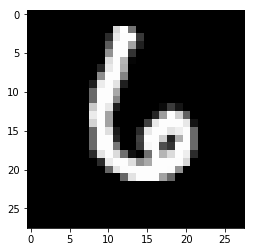

label (16,)
image (16, 28, 28, 1)


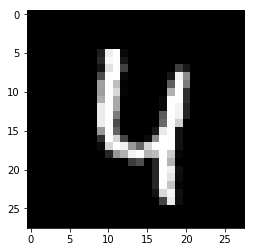

label (16,)
image (16, 28, 28, 1)


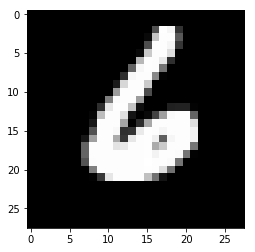

label (16,)
image (16, 28, 28, 1)


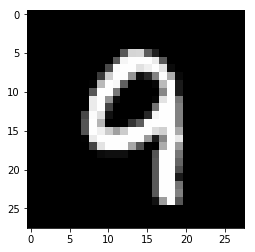

label (16,)
image (16, 28, 28, 1)


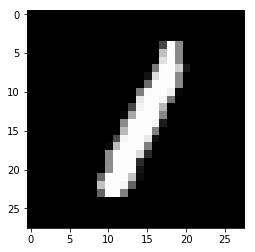

label (16,)
image (16, 28, 28, 1)


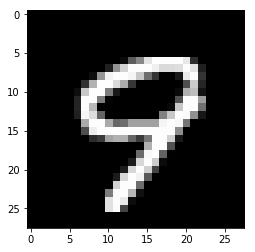

label (16,)
image (16, 28, 28, 1)


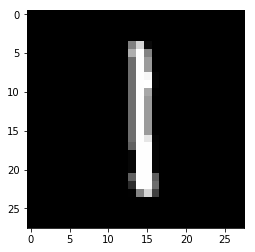

label (16,)
image (16, 28, 28, 1)


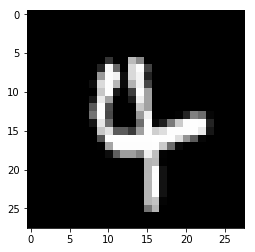

label (16,)
image (16, 28, 28, 1)


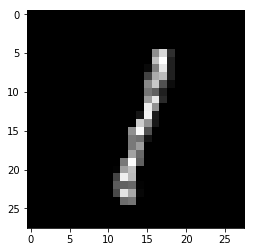

label (16,)
image (16, 28, 28, 1)


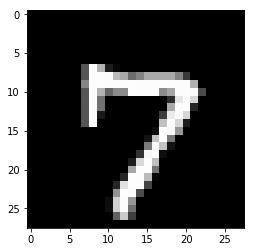

thread Done:


In [15]:
def read_and_decode(filename_queue):

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image/encoded': tf.FixedLenFeature([], tf.string),
            'image/class/label': tf.FixedLenFeature([], tf.int64),
            'image/height': tf.FixedLenFeature([], tf.int64),
            'image/width': tf.FixedLenFeature([], tf.int64),
        })

    label = tf.cast(features['image/class/label'], tf.int32)
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)

    image = tf.image.decode_jpeg(features['image/encoded'])

    image_shape = tf.stack([height, width, 1])
    image = tf.reshape(image, image_shape)

    return image, label

def preprocess_for_eval(image, height, width,
                        scope=None):
    
    with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)

        if height and width:
            # Resize the image to the specified height and width.
            image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width],
                                           align_corners=False)
            image = tf.squeeze(image, [0])
        return image

filename_list = []
num_epochs = 1

for i in range(_NUM_SHARDS):
    filename_list.append(os.path.join(_DATA_DIR,  
                                      'mnist_validation_%05d-of-%05d.tfrecord' % (i, _NUM_SHARDS)))

print (filename_list)
filename_queue = tf.train.string_input_producer(filename_list, num_epochs=num_epochs)    
    
image, label = read_and_decode(filename_queue)

image = preprocess_for_eval(image, 28, 28)

images, labels = tf.train.shuffle_batch(
            [image, label], batch_size=16, num_threads=1,
            capacity=800, allow_smaller_final_batch = True, min_after_dequeue=320 )

#min_after_dequeue: Minimum number elements in the queue after a dequeue, 
#                   used to ensure a level of mixing of elements.

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:

    sess.run(init_op)

    coord = tf.train.Coordinator() #coordinator for theads for termination
    threads = tf.train.start_queue_runners(sess=sess, coord=coord) #start threads that run the input pipeline
    
    try:
        for i in range(10):
            image, label = sess.run([images, labels])
            print ("label", np.shape(label))
            print ("image", np.shape(image))
            step = step + 1
            sample_image = np.reshape(image[0], (28, 28))
            plt.imshow(sample_image, cmap='gray')
            plt.show()
    except tf.errors.OutOfRangeError: #epoch limit has been reached
        print("Done training ", step, step*16)
    finally:
        coord.request_stop()
        coord.join(threads)
        print ("thread Done:")

## tf.contrib.dataset

input pipeline을 생성하기 위한 간편한 API
 * repeat를 이용하여 epoch 설정시, epoch 전체가 reading 된후 OutOfRangeError 발생
 * prefetch 지원 안됨


  allow_growth: true
}
allow_soft_placement: true
)
label (16,)
image (16, 28, 28, 1)


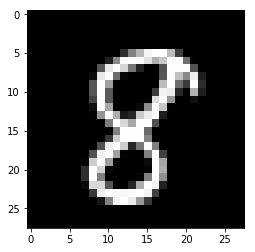

label (16,)
image (16, 28, 28, 1)


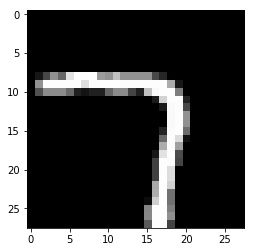

label (16,)
image (16, 28, 28, 1)


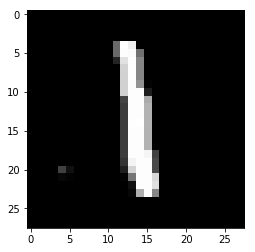

label (16,)
image (16, 28, 28, 1)


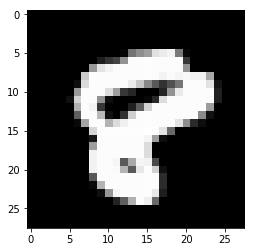

label (16,)
image (16, 28, 28, 1)


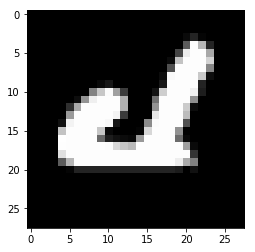

label (16,)
image (16, 28, 28, 1)


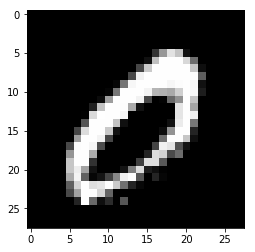

label (16,)
image (16, 28, 28, 1)


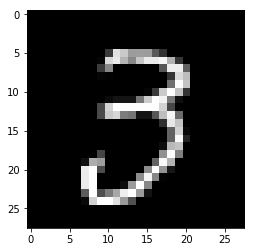

label (16,)
image (16, 28, 28, 1)


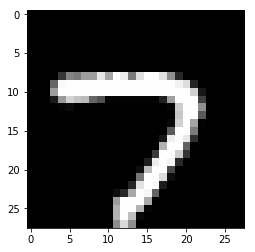

label (16,)
image (16, 28, 28, 1)


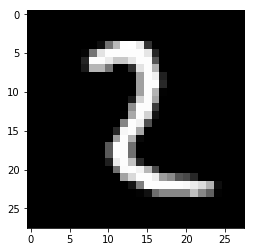

label (16,)
image (16, 28, 28, 1)


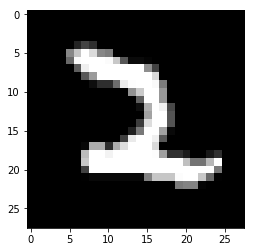

thread Done:


In [16]:
filename_list = []
num_epochs = 1
batch_size = 16

def read_and_decode(example_proto):

    #reader = tf.TFRecordReader()
    #_, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        example_proto,
        # Defaults are not specified since both keys are required.
        features={
            'image/encoded': tf.FixedLenFeature([], tf.string),
            'image/class/label': tf.FixedLenFeature([], tf.int64),
            'image/height': tf.FixedLenFeature([], tf.int64),
            'image/width': tf.FixedLenFeature([], tf.int64),
        })

    label = tf.cast(features['image/class/label'], tf.int32)
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)

    image = tf.image.decode_jpeg(features['image/encoded'])

    image_shape = tf.stack([height, width, 1])
    image = tf.reshape(image, image_shape)

    return image, label

def preprocess_for_eval(image, label, height=28, width=28,
                        scope=None):
    
    with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)

        if height and width:
            # Resize the image to the specified height and width.
            image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width],
                                           align_corners=False)
            image = tf.squeeze(image, [0])
            
        return image, label

for i in range(_NUM_SHARDS):
    filename_list.append(os.path.join(_DATA_DIR,  
                                      'mnist_validation_%05d-of-%05d.tfrecord' % (i, _NUM_SHARDS)))

dataset = tf.contrib.data.TFRecordDataset(filename_list)
dataset = dataset.map(read_and_decode)
dataset = dataset.map(preprocess_for_eval)
#dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat(num_epochs)
dataset = dataset.batch(batch_size)

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:

    sess.run(init_op)
    
    try:
        for i in range(10):
            image, label = sess.run(next_element)
            print ("label", np.shape(label))
            print ("image", np.shape(image))
            step = step + 1
            sample_image = np.reshape(image[0], (28, 28))
            plt.imshow(sample_image, cmap='gray')
            plt.show()
    except tf.errors.OutOfRangeError:
        print("Done training ", step, step*16)
    finally:
        coord.request_stop()
        coord.join(threads)
        print ("thread Done:")